Hamja: Data prep, descriptive stats, and barplot (AVOIDANCE)<br>
Investigation A

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

1) LOAD

In [15]:
DATASET1 = "dataset1.csv"
DATASET2 = "dataset2.csv"
MERGE_KEYS = ["month", "hours_after_sunset"]   # common keys
OUTPUT_MERGED = "merged_clean.csv"
PLOT_FILE = "avoidance_barplot.png"

In [16]:
df1 = pd.read_csv(DATASET1)
df2 = pd.read_csv(DATASET2)

standardize column names

In [17]:
df1.columns = [c.strip().lower().replace(" ", "_") for c in df1.columns]
df2.columns = [c.strip().lower().replace(" ", "_") for c in df2.columns]

2) CLEAN

In [18]:
df1 = df1.drop_duplicates()
df2 = df2.drop_duplicates()

numeric cleaning

In [19]:
num_cols = ["month","hours_after_sunset","rat_minutes","rat_arrival_number",
            "bat_landing_number","bat_landing_to_food"]
for col in num_cols:
    if col in df1.columns:
        df1[col] = pd.to_numeric(df1[col], errors="coerce")
    if col in df2.columns:
        df2[col] = pd.to_numeric(df2[col], errors="coerce")

In [20]:
for df in (df1, df2):
    if "hours_after_sunset" in df.columns:
        df.loc[(df["hours_after_sunset"] < -2) | (df["hours_after_sunset"] > 12), "hours_after_sunset"] = np.nan

3) MERGE

In [21]:
merged = pd.merge(df1, df2, on=MERGE_KEYS, how="inner", suffixes=("_d1","_d2"))
merged.to_csv(OUTPUT_MERGED, index=False)
print(f"Merged rows: {len(merged)} (saved -> {OUTPUT_MERGED})")

Merged rows: 32 (saved -> merged_clean.csv)


4) DESCRIPTIVE STATISTICS

In [22]:
desc_numeric = merged.select_dtypes(include="number").describe().T
print("\n=== Descriptive statistics (numeric) ===")
print(desc_numeric)


=== Descriptive statistics (numeric) ===
                           count        mean        std         min  \
bat_landing_to_food         32.0    0.414857   0.460502    0.063772   
seconds_after_rat_arrival   32.0  314.375000  70.337321  225.000000   
risk                        32.0    1.000000   0.000000    1.000000   
reward                      32.0    0.000000   0.000000    0.000000   
month                       32.0    3.250000   0.983739    2.000000   
hours_after_sunset          20.0    7.000000   0.000000    7.000000   
season                      32.0    0.625000   0.491869    0.000000   
bat_landing_number          32.0   39.687500  38.325800    1.000000   
food_availability           32.0    1.259697   1.132544    0.000000   
rat_minutes                 32.0    1.612500   3.584920    0.000000   
rat_arrival_number          32.0    0.562500   0.981687    0.000000   

                                  25%         50%      75%         max  
bat_landing_to_food          0.0

5) AVOIDANCE ANALYSIS (bar plot)

rat presence if arrivals >0 or minutes >0

In [23]:
rats_present = (merged.get("rat_arrival_number",0) > 0) | (merged.get("rat_minutes",0) > 0)
merged["rats_present"] = np.where(rats_present, "Rats present", "No rats")

outcome metric

In [24]:
if "bat_landing_number" in merged.columns:
    landing_metric = "bat_landing_number"
else:
    landing_metric = "bat_landing_to_food"

In [25]:
avoidance_summary = merged.groupby("rats_present")[landing_metric].mean().reset_index()
print("\n=== Avoidance summary (group means) ===")
print(avoidance_summary)


=== Avoidance summary (group means) ===
   rats_present  bat_landing_number
0       No rats           46.142857
1  Rats present           27.363636


plot

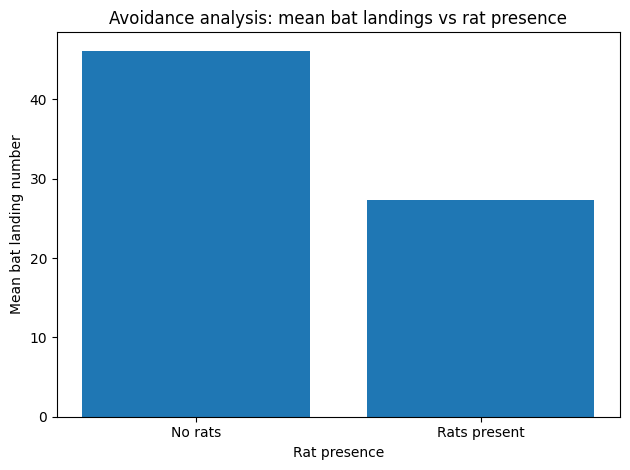

In [26]:
plt.figure()
plt.bar(avoidance_summary["rats_present"], avoidance_summary[landing_metric])
plt.title("Avoidance analysis: mean bat landings vs rat presence")
plt.xlabel("Rat presence")
plt.ylabel(f"Mean {landing_metric.replace('_',' ')}")
plt.tight_layout()
plt.savefig(PLOT_FILE, dpi=160)
plt.show()